In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde


In [21]:
import os

os.listdir("/kaggle/input/india-air-quality-data")


['data.csv']

In [22]:
data = pd.read_csv("/kaggle/input/india-air-quality-data/data.csv",encoding="latin1")


/tmp/ipykernel_55/1652171090.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/kaggle/input/india-air-quality-data/data.csv",encoding="latin1")


In [23]:
data.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [24]:
data.columns

Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')

In [25]:
x = data["no2"]

x

0         17.4
1          7.0
2         28.5
3         14.7
4          7.5
          ... 
435737    50.0
435738    46.0
435739     NaN
435740     NaN
435741     NaN
Name: no2, Length: 435742, dtype: float64

In [26]:
x = x.dropna()


In [27]:
x = x.values
x = x.reshape(len(x), 1)

In [28]:
r = 102303163

a = 0.5 * (r % 7)
b = 0.3 * ((r % 5) + 1)

z = x + a * np.sin(b * x)


In [30]:
sc = StandardScaler()
z = sc.fit_transform(z)


In [31]:
z_real = torch.tensor(z).float()


In [32]:
G = nn.Sequential(
    nn.Linear(1, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)


In [37]:
D = nn.Sequential(
    nn.Linear(1, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)


In [38]:
loss_fn = nn.BCELoss()

opt_g = optim.Adam(G.parameters(), lr=0.001)
opt_d = optim.Adam(D.parameters(), lr=0.001)


In [39]:
epochs = 1500
batch = 32

for i in range(epochs):

    index = np.random.randint(0, len(z_real), batch)
    real_data = z_real[index]

    real_label = torch.ones(batch, 1)
    fake_label = torch.zeros(batch, 1)

    noise = torch.randn(batch, 1)
    fake_data = G(noise)

    d_real = D(real_data)
    d_fake = D(fake_data.detach())

    d_loss = loss_fn(d_real, real_label) + loss_fn(d_fake, fake_label)

    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    noise = torch.randn(batch, 1)
    fake_data = G(noise)
    d_fake = D(fake_data)

    g_loss = loss_fn(d_fake, real_label)

    opt_g.zero_grad()
    g_loss.backward()
    opt_g.step()

    if i % 300 == 0:
        print(i, d_loss.item(), g_loss.item())


0 1.3966656923294067 0.6919984817504883
300 1.4647612571716309 0.678161084651947
600 1.3666694164276123 0.6595938205718994
900 1.3846323490142822 0.6591137051582336
1200 1.3775814771652222 0.6961320638656616


In [40]:
noise = torch.randn(5000, 1)
z_fake = G(noise)
z_fake = z_fake.detach().numpy()
z_fake = z_fake.flatten()


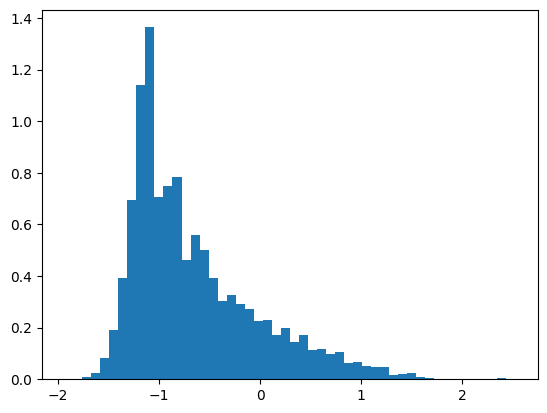

In [41]:
plt.hist(z_fake, bins=50, density=True)
plt.show()


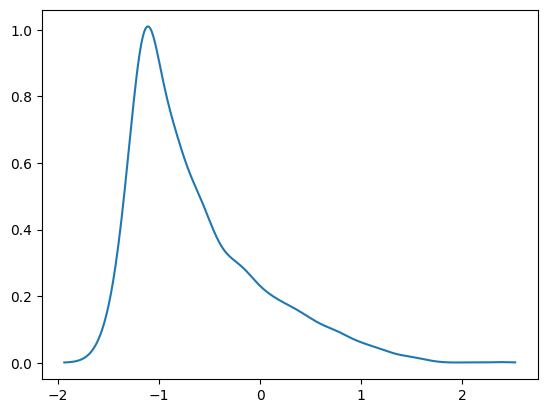

In [42]:
k = gaussian_kde(z_fake)

x1 = np.linspace(min(z_fake), max(z_fake), 300)
y1 = k(x1)

plt.plot(x1, y1)
plt.show()
